In [1]:
import torch.nn as nn
import torchvision
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

You may want to modify the class's out features, so that they fit the image shape accordingly

In [2]:
img_shape = 28
compress_size = 16
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=compress_size
        )
        self.encoder_output_layer = nn.Linear(
            in_features=compress_size, out_features=compress_size
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compress_size, out_features=compress_size
        )
        self.decoder_output_layer = nn.Linear(
            in_features=compress_size, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

In [3]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=img_shape*img_shape).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
root_path = '../data/28x28'

train_dataset = torchvision.datasets.MNIST(
    root= root_path, train=True, transform=transform, download=False
)

test_dataset = torchvision.datasets.MNIST(
    root= root_path, train=False, transform=transform, download=False
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

/Users/cristianespinosa/opt/anaconda3/envs/tensor/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631159818/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
epochs = 20
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, img_shape*img_shape).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/20, loss = 0.086137
epoch : 2/20, loss = 0.066205
epoch : 3/20, loss = 0.063122
epoch : 4/20, loss = 0.061653
epoch : 5/20, loss = 0.061124
epoch : 6/20, loss = 0.060882
epoch : 7/20, loss = 0.060733
epoch : 8/20, loss = 0.060634
epoch : 9/20, loss = 0.060554
epoch : 10/20, loss = 0.060499
epoch : 11/20, loss = 0.060451
epoch : 12/20, loss = 0.060416
epoch : 13/20, loss = 0.060388
epoch : 14/20, loss = 0.060363
epoch : 15/20, loss = 0.060343
epoch : 16/20, loss = 0.060319
epoch : 17/20, loss = 0.060305
epoch : 18/20, loss = 0.060290
epoch : 19/20, loss = 0.060276
epoch : 20/20, loss = 0.060266


In [6]:
test_examples = None
test_examples = []
reconstruction = []
i = 0
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples.append(batch_features.view(-1, img_shape*img_shape))
        reconstruction.append( model(test_examples[i]) )
        i += 1

Essentially, you have 32 images of size 28x28 (because 28x28 flattened is 784)

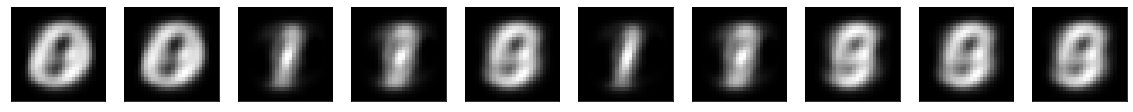

In [8]:
with torch.no_grad():
    number = 10
    i = 11
    fig = plt.figure(figsize=(20, 4))
#     plt.suptitle("Original", fontsize=16)
    
#     for index in range(number):
# #         display original
#         ax = plt.subplot(2, number, index + 1)
# #         ax.set_title("Original")
#         plt.imshow(test_examples[i][index].numpy().reshape(img_shape,img_shape))
#         plt.gray()
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
#     fig.title.set_text('First Plot')
    
#     plt.suptitle("Decoded", fontsize=16)
    for index in range(number):
        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
#         ax.set_title("Decoded")
        plt.imshow(reconstruction[i][index].numpy().reshape(img_shape,img_shape))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()